In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import os
import matplotlib.pyplot as plt
import json
import pandas as pd
%matplotlib notebook
from pygeotools.lib import iolib, timelib, malib, geolib
from imview.lib import pltlib
import numpy as np
import glob
import multiprocessing as mp

In [49]:
source = 'WV'
round2 = False

if source == 'WV':
    topdir = '/nobackupp8/deshean/hma/dem_coreg'
    globstr = '*track/2*align/*align_stats.json'
    if round2:
        globstr = '*track/2*align/2*align/*align_stats.json'
    bad_globstr = '*track/%s/2*align/*align_stats.json'
elif source =='ASTER':
    topdir = '/nobackupp8/deshean/hma/aster/dsm'
    globstr = '2*/AST*align/*align_stats.json'
    bad_globstr = '%s/AST*align/*align_stats.json'
    if round2:
        globstr = '2*/AST*align/AST*align/*align_stats.json'
    
#Directory for bad align files
baddir = os.path.join(topdir, 'dem_align_%s_bad' % source)
if round2:
    baddir += '_round2'
if not os.path.exists(baddir): os.makedirs(baddir) 
    
prefix = os.path.join(topdir, 'dem_align_%s' % source)
if round2:
    prefix += '_round2'

json_fn_list = glob.glob(os.path.join(topdir, globstr))
#This was a hack to reintegrate the bad files for analysis/plotting
#if not round2:
#    json_fn_list.extend(glob.glob(os.path.join(topdir, bad_globstr % os.path.split(baddir)[-1])))

In [50]:
len(json_fn_list)

5655

See nyc-taxi example from dask pd website, use dask to load all *json into df, rather than mp.Pool

In [51]:
#Function to parse json
def parse_json(json_fn):
    with open(json_fn, 'r') as f:
        d = json.load(f)
        #dt = timelib.fn_getdatetime(os.path.split(d['src_fn'])[-1][0:12])
        dt = timelib.fn_getdatetime(os.path.split(d['src_fn'])[-1])
        #Check for nmad - this was updated from 'mad' recently
        #if 'nmad' not in d['before_filt'].keys():
        #    print(json_fn)
        out = [dt, d['src_fn'], d['align_fn'], \
               d['shift']['dx'], d['shift']['dy'], d['shift']['dz'], d['shift']['dm'], \
               d['center_coord']['x'], d['center_coord']['y'], \
               d['before_filt']['med'], d['before_filt']['nmad'], \
               d['before_filt']['p16'], d['before_filt']['p84'], d['before_filt']['spread'], \
               d['after_filt']['med'], d['after_filt']['nmad'], \
               d['after_filt']['p16'], d['after_filt']['p84'], d['after_filt']['spread']]
        return out

#Parallel read
pool = mp.Pool()
#out = [pool.apply(parse_json, args=(json_fn,)) for json_fn in json_fn_list]
out = pool.map(parse_json, json_fn_list)

#out = []
#for i,json_fn in enumerate(json_fn_list):
#    out.append(parse_json(json_fn))

#Can read directly in pandas, but need to reformat
#df = pd.read_json(json_fn, orient='index')

In [52]:
#outa = np.array(out)
columns=['dt','src_fn', 'align_fn', 'dx', 'dy', 'dz', 'dm', 'cx', 'cy', \
         'med_before', 'nmad_before', 'p16_before', 'p84_before', 'spread_before', \
         'med_after', 'nmad_after', 'p16_after', 'p84_after', 'spread_after']
df = pd.DataFrame(out, columns=columns)
df = df.sort_values(by='dt')

#df = pd.DataFrame(outa, index=outa[:,0], columns=['dt','src_fn','med_before', 'p16_before', 'p84_before', 'med_after', 'p16_after', 'p84_after'])
#df = df.sort_index()

In [53]:
df.columns

Index(['dt', 'src_fn', 'align_fn', 'dx', 'dy', 'dz', 'dm', 'cx', 'cy',
       'med_before', 'nmad_before', 'p16_before', 'p84_before',
       'spread_before', 'med_after', 'nmad_after', 'p16_after', 'p84_after',
       'spread_after'],
      dtype='object')

In [54]:
df.mean(), df.median(), df.std()

(dx               1.745790e-01
 dy               3.267335e-01
 dz              -1.675173e+00
 dm               5.443950e+00
 cx               4.758406e+05
 cy               3.919117e+06
 med_before       1.671553e+00
 nmad_before      2.818534e+00
 p16_before      -1.429786e+00
 p84_before       4.798028e+00
 spread_before    3.113907e+00
 med_after       -2.925563e-04
 nmad_after       2.659314e+00
 p16_after       -2.955658e+00
 p84_after        2.968691e+00
 spread_after     2.962174e+00
 dtype: float64, dx               1.666894e-01
 dy               3.107523e-01
 dz              -1.679688e+00
 dm               4.125581e+00
 cx               4.746027e+05
 cy               3.925839e+06
 med_before       1.696289e+00
 nmad_before      2.306428e+00
 p16_before      -8.911133e-01
 p84_before       4.269043e+00
 spread_before    2.627136e+00
 med_after        0.000000e+00
 nmad_after       2.142820e+00
 p16_after       -2.500977e+00
 p84_after        2.444336e+00
 spread_after     2.498

<IPython.core.display.Javascript object>


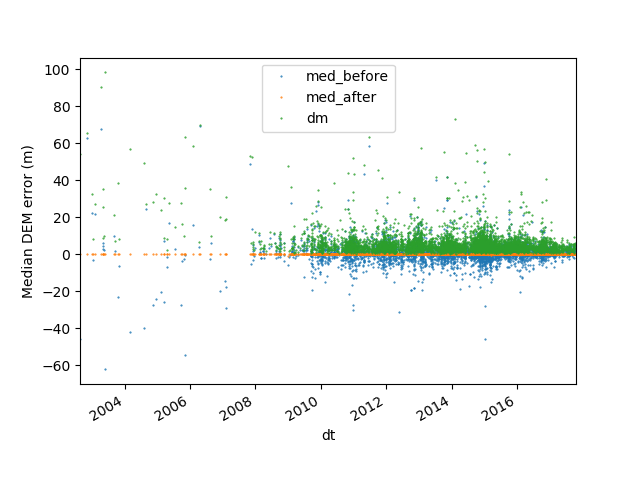

(731083.7305555556, 736623.2333333333)

In [55]:
med_ax = df.plot('dt', ['med_before', 'med_after', 'dm'], ls='none', marker='.', ms=1)
med_ax.set_ylabel('Median DEM error (m)')
med_ax.set_xlim(df['dt'].min(), df['dt'].max())
#med_ax.set_ylim(-100,100)

In [56]:
C = 3.0
def outlier_filter(df, col=None, C=3.0, perc=None, absdiff=None):
    df_mean = df[col].mean()
    #df_mean = df[col].median()
    if absdiff is not None:
        minval = df_mean - absdiff
        maxval = df_mean + absdiff
    elif perc is not None:
        minval, maxval = malib.calcperc(df[col], perc=perc)
    else:
        df_std = df[col].std()
        #df_std = malib.mad(df[col])
        minval = df_mean - C * df_std
        maxval = df_mean + C * df_std
    idx = (df[col] < minval) | (df[col] > maxval)
    print("Removing outliers: %s, (%0.2f to %0.2f), %i" % (col,minval,maxval,idx.sum()))
    #return df[~idx]
    return idx

In [57]:
dm_idx = False
med_after_idx = False
spread_idx = False 
p16_idx = False 
p84_idx = False
med_idx = False 
nmad_idx = False

if source == 'WV':
    #WV/GE
    print(source, 'round1')
    max_dm = 20
    ylim=(-20, 20)
    spread_idx = outlier_filter(df, col='spread_after', perc=(0.0, 99.9))
    p16_idx = outlier_filter(df, col='p16_after', perc=(2, 100.0))
    p84_idx = outlier_filter(df, col='p84_after', perc=(0.0, 98))
elif source == 'ASTER':
    #ASTER
    ylim=(-60, 60)
    max_dm = 60
    if round2:
        print(source, 'round2')
        spread_idx = outlier_filter(df, col='spread_after', perc=(0.0, 99.95))
        p16_idx = outlier_filter(df, col='p16_after', perc=(0.05, 99.9))
        p84_idx = outlier_filter(df, col='p84_after', perc=(0.01, 99.9))
    else:
        print(source, 'round1')
        spread_idx = outlier_filter(df, col='spread_after')
        p16_idx = outlier_filter(df, col='p16_after', perc=(0.5, 100.0))
        p84_idx = outlier_filter(df, col='p84_after', perc=(0.0, 99.5))
        

med_after_idx = outlier_filter(df, col='med_after', absdiff=1)

#dm_idx = outlier_filter(df, col='dm', absdiff=max_dm)
dm_idx = (df['dm'] > max_dm)
print("Removing outliers, dm thresh (%0.2f m): %i" % (max_dm, dm_idx.sum()))

med_idx = (df['med_after'].abs() > 1.1*df['med_before'].abs())
print("Removing outliers, med increase: %i" % med_idx.sum())

#Check if nmad after is larger than before
nmad_idx = (df['nmad_after'] > 1.1*df['nmad_before'])
print("Removing outliers, nmad increase: %i" % nmad_idx.sum())

#idx = dm_idx | med_after_idx | spread_idx
idx = dm_idx | med_after_idx | spread_idx | p16_idx | p84_idx | med_idx | nmad_idx
print(idx.sum(), df.shape[0], '%0.2f%%' % (100*idx.sum()/df.shape[0]))

print(df.shape)
df_filt = df[~idx]
print(df_filt.shape)


WV round1
Removing outliers: spread_after, (0.20 to 30.37), 6
Removing outliers: p16_after, (-9.05 to -0.21), 114
Removing outliers: p84_after, (0.19 to 8.81), 114
Removing outliers: med_after, (-1.00 to 1.00), 0
Removing outliers, dm thresh (20.00 m): 114
Removing outliers, med increase: 0
Removing outliers, nmad increase: 10
234 5655 4.14%
(5655, 19)
(5421, 19)


In [58]:
#Hack, as the default pandas dt format won't work with the vectorized np_dt2decyear
#dt = timelib.dt2o(df['dt'])
#dt = outa[:,0]
#dt = timelib.np_dt2decyear(df['dt'])
dt = timelib.np_dt2decyear(timelib.o2dt(timelib.dt2o(df['dt'])))
dt

array([2002.63750381, 2002.85125761, 2003.01006849, ..., 2017.79807648,
       2017.80049467, 2017.80326484])

In [59]:
#C = 3.5
#ylim = (C * df['p16_after'].mean(), C * df['p84_after'].mean())
#ylim = (-20, 20)
#idx = (df['p16_after'] < ylim[0]) | (df['p84_after'] > ylim[1]) 
#print(ylim)
#ylim=(-20, 20)
#ylim=(-60, 60)

<IPython.core.display.Javascript object>


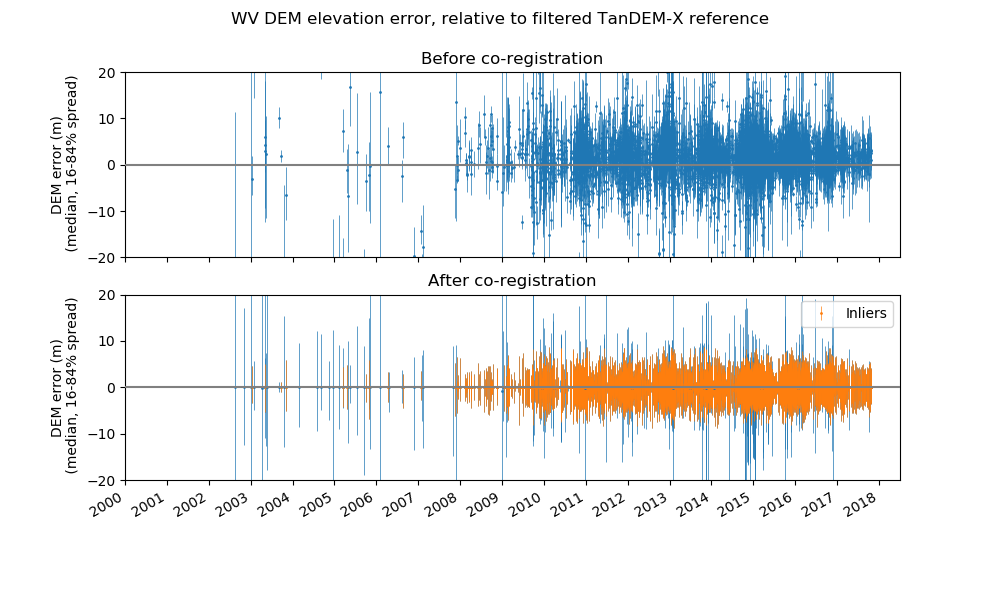

In [60]:
#Should isolate alongtrack and crosstrack
#Potentially plot different colors for different sensors

f, axa = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,6))
f.suptitle("%s DEM elevation error, relative to filtered TanDEM-X reference" % source)
axa[0].set_title("Before co-registration")
axa[1].set_title("After co-registration")
#ax.plot(df['dt'], df['med_before'], ls='none', marker='o')
errprop={'ls':'none', 'alpha':1.0, 'elinewidth':0.5, 'marker':'.', 'ms':2}
yerr=np.array([df['med_before'] - df['p16_before'], df['p84_before'] - df['med_before']])
axa[0].errorbar(dt, df['med_before'], yerr=yerr, **errprop)
#yerr=np.array([df_filt['med_before'] - df_filt['p16_before'], df_filt['p84_before'] - df_filt['med_before']])
#axa[0].errorbar(dt[~idx], df_filt['med_before'], marker='', yerr=yerr, **errprop)
yerr=np.array([df['med_after'] - df['p16_after'], df['p84_after'] - df['med_after']])
axa[1].errorbar(dt, df['med_after'], yerr=yerr, label=None, **errprop)
yerr=np.array([df_filt['med_after'] - df_filt['p16_after'], df_filt['p84_after'] - df_filt['med_after']])
axa[1].errorbar(dt[~idx], df_filt['med_after'], label='Inliers', yerr=yerr, **errprop)
axa[0].set_ylim(*ylim)
#axa[0].set_xlim(dt.min(), dt.max())
axa[0].set_xlim(2000, 2018.5)
start, end = axa[0].get_xlim()
axa[1].legend()
for ax in axa:
    ax.set_ylabel('DEM error (m)\n (median, 16-84% spread)')
    ax.axhline(0, c='0.5', zorder=99)
    ax.xaxis.set_ticks(np.arange(start, end, 1.0))
    #ax.grid()

"""
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
"""
f.autofmt_xdate()

In [32]:
print(df_filt.mean())
print(df_filt.std())
print(df_filt.median())

dx              -5.346519e+00
dy               4.806308e+00
dz               1.298854e+01
dm               2.219503e+01
cx               4.989762e+05
cy               3.837523e+06
med_before      -1.288793e+01
nmad_before      8.179356e+00
p16_before      -2.109658e+01
p84_before      -4.348779e+00
spread_before    8.373903e+00
med_after       -2.484867e-05
nmad_after       6.981544e+00
p16_after       -6.980984e+00
p84_after        7.341996e+00
spread_after     7.161490e+00
dtype: float64
dx                   13.534507
dy                    9.194705
dz                    9.069593
dm                    8.817134
cx               159619.275878
cy               459090.153700
med_before            9.074769
nmad_before           3.149225
p16_before            9.554463
p84_before            9.748873
spread_before         3.228265
med_after             0.000951
nmad_after            1.957954
p16_after             2.020843
p84_after             2.293114
spread_after          2.102361
dtype: fl

In [61]:
df[idx]

,dt,src_fn,align_fn,dx,dy,dz,dm,cx,cy,med_before,nmad_before,p16_before,p84_before,spread_before,med_after,nmad_after,p16_after,p84_after,spread_after
1575,2002-08-21 17:32:00,crosstrack/20020821_1732_10100100010F3200_1010...,crosstrack/20020821_1732_10100100010F3200_1010...,-18.585779,-26.387859,43.615723,54.259391,502275.209132,4.983833e+06,-45.895691,43.621867,-82.250918,11.376436,46.813677,-0.000488,42.090855,-40.242295,52.172363,46.207329
956,2002-11-07 17:01:00,crosstrack/20021107_1701_1010010001681000_1010...,crosstrack/20021107_1701_1010010001681000_1010...,4.813660,18.528873,-62.965698,65.811622,536736.099537,4.781570e+06,62.912720,16.075677,49.402832,80.425430,15.511299,-0.002075,16.003284,-12.537354,17.024170,14.780762
2486,2003-01-04 16:12:00,crosstrack/20030104_1612_10100100018A5300_1010...,crosstrack/20030104_1612_10100100018A5300_1010...,22.558986,4.748131,-23.141602,32.664757,316054.981954,3.384182e+06,22.387207,40.250997,-20.086914,51.804688,35.945801,0.001953,39.199857,-42.729062,28.851074,35.790068
2711,2003-02-02 17:16:00,crosstrack/20030202_1716_1010010001987200_1010...,crosstrack/20030202_1716_1010010001987200_1010...,18.051955,-5.684917,-19.536499,27.200481,736086.361736,4.822676e+06,21.738770,8.928177,14.433262,30.856445,8.211592,0.000549,5.293436,-4.853296,5.706348,5.279822
812,2003-04-10 17:12:00,crosstrack/20030410_1712_1010010001CD1F00_1010...,crosstrack/20030410_1712_1010010001CD1F00_1010...,-9.375322,11.368679,-89.044800,90.255858,586876.958591,4.005978e+06,67.956299,27.381769,44.443086,91.358887,23.457900,-0.049316,35.365222,-33.786895,29.685879,31.736387
2434,2003-05-02 17:53:00,crosstrack/20030502_1753_1010010001DEC600_1010...,crosstrack/20030502_1753_1010010001DEC600_1010...,22.282379,-12.276588,0.788452,25.452714,378425.231608,3.880010e+06,6.022705,19.265475,-9.279053,27.754980,18.517017,-0.001953,14.872874,-11.009790,21.021973,16.015881
4956,2003-05-07 04:45:00,alongtrack/20030507_0445_1010010001E01600_1010...,alongtrack/20030507_0445_1010010001E01600_1010...,31.470057,-15.345716,-1.613037,35.049356,492012.475251,3.094870e+06,2.903809,15.513729,-12.282090,17.982949,15.132520,-0.000977,5.524278,-5.234082,6.324609,5.779346
3073,2003-05-13 17:28:00,crosstrack/20030513_1728_1010010001E6E100_1010...,crosstrack/20030513_1728_1010010001E6E100_1010...,9.211890,0.724981,-3.015564,9.719987,597209.952144,3.648996e+06,2.254150,9.674725,-11.539907,10.520986,11.030447,-0.001099,8.663763,-12.770059,7.476562,10.123311
2392,2003-05-26 17:23:00,crosstrack/20030526_1723_1010010001F04400_1010...,crosstrack/20030526_1723_1010010001F04400_1010...,60.559150,-43.123434,64.324890,98.309372,666641.608085,3.578308e+06,-62.154541,34.110659,-96.573721,-30.023008,33.275356,-0.001831,22.763032,-17.930439,29.364531,23.647485
5184,2003-09-01 05:26:00,alongtrack/20030901_0526_10100100023E9000_1010...,alongtrack/20030901_0526_10100100023E9000_1010...,18.037940,4.919690,-9.534180,20.987406,262931.752481,4.632023e+06,9.998291,2.000931,7.816084,12.499756,2.341836,-0.000244,0.971870,-1.009521,1.107178,1.058350


In [62]:
df[idx]['align_fn'].to_csv(prefix+'_bad_fn.txt', index=False)
df[~idx]['align_fn'].to_csv(prefix+'_good_fn.txt', index=False)

In [63]:
baddir

'/nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad'

In [64]:
import shutil
for i in df[idx]['align_fn']:
    dirname = os.path.join(topdir, os.path.split(i)[0])
    print("Moving %s to %s" % (dirname, baddir))
    shutil.move(dirname, baddir)

Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20020821_1732_10100100010F3200_1010010001087800-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20021107_1701_1010010001681000_101001000165AE00-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20030104_1612_10100100018A5300_1010010001872000-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20030202_1716_1010010001987200_10100100019C2E00-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20030410_1712_1010010001CD1F00_1010010001C8EE00-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20030502_1753

Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20141010_0557_1030010039A8E200_10200100357A9100-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20141010_0557_1030010039A8E200_102001003312A700-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20141010_0557_1030010038AB5D00_102001003312A700-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20141024_0542_1040010003248300_1030010039A5DA00-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20141024_0542_10400100030EE100_1030010039A5DA00-DEM_8m_dzfilt_-200_200_dem_align to /nobackupp8/deshean/hma/dem_coreg/dem_align_WV_bad
Moving /nobackupp8/deshean/hma/dem_coreg/crosstrack/20141024_0542

In [65]:
def make_plot3d(df, title=None, orthogonal_fig=True, maxdim=None):
    x = df['dx']
    y = df['dy']
    z = df['dz']
    cmean = np.mean([x,y,z], axis=1)
    cstd = np.std([x,y,z], axis=1)
    cmed = np.median([x,y,z], axis=1)
    cnmad = malib.mad([x,y,z], axis=1)
    x_corr = x - cmean[0]
    y_corr = y - cmean[1]
    z_corr = z - cmean[2]

    ce90 = geolib.CE90(x,y)
    ce90_corr = geolib.CE90(x_corr,y_corr)
    le90 = geolib.LE90(z)
    le90_corr = geolib.LE90(z_corr)

    coefs = [ce90, ce90, le90]
    if maxdim is None:
        #maxdim = np.ceil(np.max([np.max(np.abs([x, y, z])), ce90, le90]))
        maxdim = np.ceil(np.max([np.percentile(np.abs([x, y, z]), 99), ce90, le90]))

    if orthogonal_fig:
        from matplotlib.patches import Ellipse
        #fig_ortho, axa = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,5))
        fig_ortho, axa = plt.subplots(1, 3, figsize=(10,5))
        title = 'Co-registration Translation Vector Components, n=%i\n' % x.shape[0]
        title += 'mean: (%0.2f, %0.2f, %0.2f), std: (%0.2f, %0.2f, %0.2f)\n' % (tuple(cmean) + tuple(cstd))
        title += 'med: (%0.2f, %0.2f, %0.2f), nmad: (%0.2f, %0.2f, %0.2f)\n' % (tuple(cmed) + tuple(cnmad))
        title += 'CE90: %0.2f (Bias-corrected: %0.2f), LE90: %0.2f (Bias-corrected: %0.2f)' % (ce90, ce90_corr, le90, le90_corr)
        plt.suptitle(title)

        dot_prop={'color':'k', 'linestyle':'None', 'marker':'.', 'ms':3, 'label':'ICP correction vector', 'alpha':0.1}
        mean_prop={'color':'r', 'linestyle':'None', 'marker':'o', 'label':'Mean'}
        ell_prop={'linewidth':0, 'alpha':0.3, 'label':'CE90/LE90'}

        for ax in axa:
            ax.set_xlim(-maxdim, maxdim)
            ax.set_ylim(-maxdim, maxdim)
            ax.minorticks_on()
            ax.set_aspect('equal')

        axa[0].plot(x, y, **dot_prop)
        axa[0].plot(cmean[0], cmean[1], **mean_prop)
        axa[0].set_xlabel('X offset (m)')
        axa[0].set_ylabel('Y offset (m)')
        e = Ellipse((0,0), 2*ce90, 2*ce90, **ell_prop)
        axa[0].add_artist(e)
        axa[0].legend(prop={'size':8}, numpoints=1, loc='upper left')

        axa[1].plot(x, z, **dot_prop)
        axa[1].plot(cmean[0], cmean[2], **mean_prop)
        axa[1].set_xlabel('X offset (m)')
        axa[1].set_ylabel('Z offset (m)')
        e = Ellipse((0,0), 2*ce90, 2*le90, **ell_prop)
        axa[1].add_artist(e)

        axa[2].plot(y, z, **dot_prop)
        axa[2].plot(cmean[1], cmean[2], **mean_prop)
        axa[2].set_xlabel('Y offset (m)')
        axa[2].set_ylabel('Z offset (m)')
        e = Ellipse((0,0), 2*ce90, 2*le90, **ell_prop)
        axa[2].add_artist(e)

        plt.tight_layout()

        #Note: postscript doesn't properly handle tansparency
        #fig_fn = '%s_translation_vec_local_meters_orthogonal.pdf' % out_fn_prefix
        #plt.savefig(fig_fn, dpi=600, bbox_inches='tight')

In [66]:
def make_map(df):
    x = df['dx']
    y = df['dy']
    z = df['dz']
    cx = df['cx']
    cy = df['cy']
    f, axa = plt.subplots(3, sharex=True, sharey=True, figsize=(5,10))
    maxdim = np.ceil(np.percentile(np.abs([x, y, z]), 99))
    #vmin, vmax = (-15, 15)
    vmin, vmax = (-maxdim, maxdim)
    s=5
    cmap='RdYlBu'
    opt={'edgecolor':'k', 'vmin':vmin, 'vmax':vmax, 'cmap':cmap, 's':s, 'lw':0.3}
    sc = axa[0].scatter(cx, cy, c=x, **opt)
    axa[0].set_title("X-offset required to align")
    axa[1].scatter(cx, cy, c=y, **opt)
    axa[1].set_title("Y-offset required to align")
    axa[2].scatter(cx, cy, c=z, **opt)
    axa[2].set_title("Z-offset required to align")
    for ax in axa:
        #ax.set_aspect('equal')
        pltlib.add_cbar(ax, sc, clim=(vmin, vmax))
    
    #fig_fn = '%s_map.png' % out_fn_prefix
    #f.savefig(fig_fn, dpi=300, bbox_inches='tight')

Creating plot


<IPython.core.display.Javascript object>


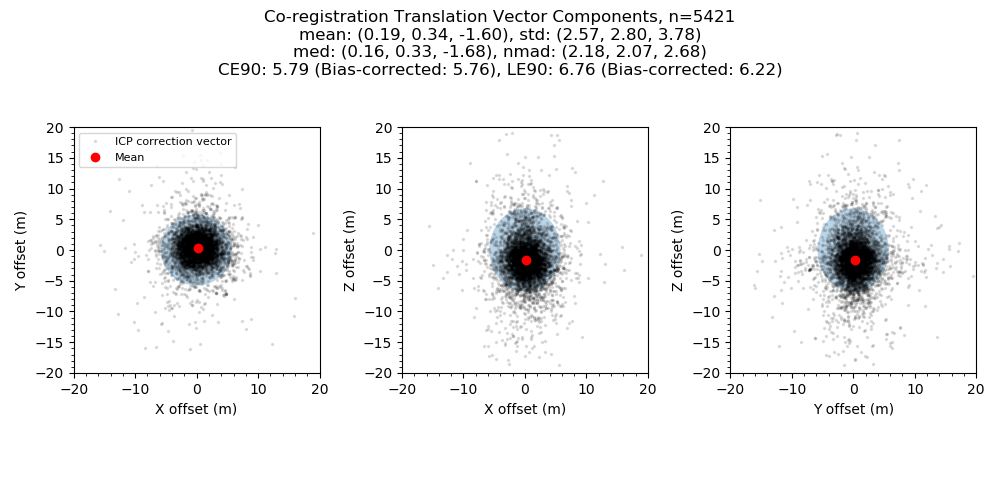

In [68]:
df_filt_sort = df_filt.sort_values(by='dm', ascending=False)
print("Creating plot")
make_plot3d(df_filt_sort, maxdim=max_dm)
#print("Creating map")
#make_map(df_filt_sort)